<a href="https://colab.research.google.com/github/vaidik627/VOIS_AICTE_Oct2025_MajorProject_Vaidik_Sharma/blob/main/Netflix_Project_Analysis_Fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Netflix Dataset Analysis

In [ ]:

# Imports & settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)

DATA_PATH = "/content/Netflix Dataset.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head(5)


Shape: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor."
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive."
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly, Christopher Plummer, Crispin Glover, Martin Landau, Fred Tatasciore, Alan Oppenheimer, Tom Kane",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi & Fantasy","In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aaron Yoo, Liza Lapira, Jacob Pitts, Laurence Fishburne, Jack McGee, Josh Gad, Sam Golzari, Helen Carey, Jack Gilpin",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack.


In [ ]:

# Standardize/clean columns using the ACTUAL names:
df_clean = df.copy()

# Strip whitespace on common text cols
for col in ['Title','Director','Cast','Country','Rating','Type','Description','Category','Release_Date']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.strip()

# Parse Release_Date -> datetime and year_added/month_added
df_clean['date_added'] = pd.to_datetime(df_clean['Release_Date'], errors='coerce')
df_clean['year_added'] = df_clean['date_added'].dt.year
df_clean['month_added'] = df_clean['date_added'].dt.month

# Missing values handling
for col in ['Director','Cast','Country']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace({'nan': np.nan}).fillna('Unknown')

# Remove duplicates
df_clean = df_clean.drop_duplicates()

print("Cleaned shape:", df_clean.shape)
df_clean.head(3)


Cleaned shape: (7787, 14)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description,date_added,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.",2020-08-14,2020.0,8.0
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive.",2016-12-23,2016.0,12.0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp.",2018-12-20,2018.0,12.0



## Movies vs TV Shows (Category)
- Uses **Category** (`Movie` vs `TV Show`)
- Over-time trends use **year_added** because production year is not present; we use the date titles were added to Netflix.


,count
Category,
Movie,5377
TV Show,2410


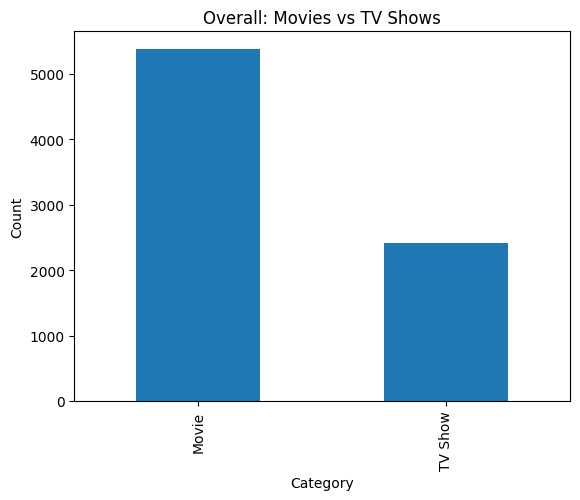

In [ ]:

# Overall split
if 'Category' in df_clean.columns:
    split_counts = df_clean['Category'].value_counts()
    display(split_counts)
    split_counts.plot(kind='bar', title='Overall: Movies vs TV Shows')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()
else:
    print("Column 'Category' not found.")


Category,Movie,TV Show
year_added,,
2012.0,3,0
2013.0,6,5
2014.0,19,6
2015.0,58,30
2016.0,258,185
2017.0,864,361
2018.0,1255,430
2019.0,1497,656
2020.0,1312,697


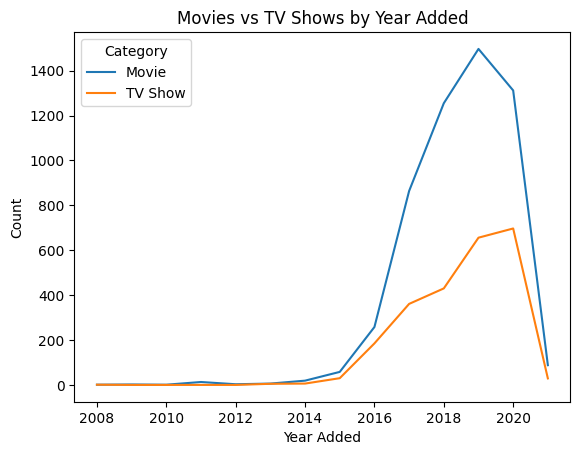

In [ ]:

# Trend over time by year_added
if set(['Category','year_added']).issubset(df_clean.columns):
    yearly = (df_clean.dropna(subset=['year_added'])
                        .groupby(['year_added','Category'])
                        .size()
                        .unstack(fill_value=0)
                        .sort_index())
    display(yearly.tail(10))
    yearly.plot(kind='line', title='Movies vs TV Shows by Year Added')
    plt.xlabel('Year Added')
    plt.ylabel('Count')
    plt.show()
else:
    print("Columns missing for yearly trend.")



## Genres (`Type` column)
- The `Type` column contains comma-separated genres (e.g., "Dramas, International Movies").


,count
Type,
International Movies,2437
Dramas,2106
Comedies,1471
International TV Shows,1199
Documentaries,786
Action & Adventure,721
TV Dramas,704
Independent Movies,673
Children & Family Movies,532


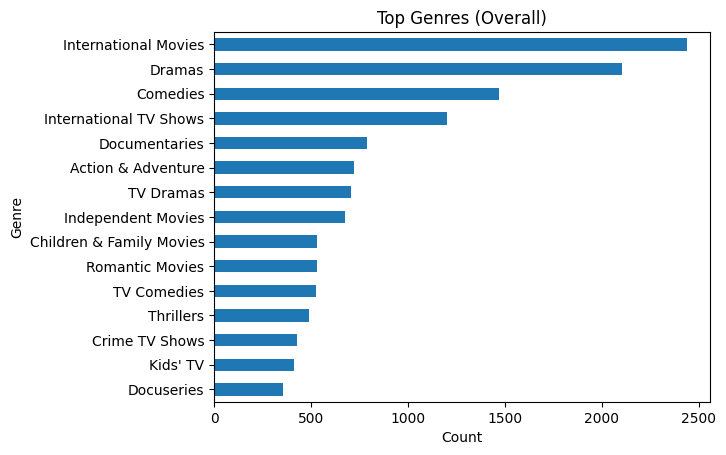

In [ ]:

def split_explode_count(series, sep=','):
    s = series.dropna().astype(str).str.split(sep).explode().str.strip()
    s = s[s!='']
    return s.value_counts()

if 'Type' in df_clean.columns:
    genre_counts = split_explode_count(df_clean['Type'])
    display(genre_counts.head(20))
    genre_counts.head(15).sort_values(ascending=True).plot(kind='barh', title='Top Genres (Overall)')
    plt.xlabel('Count'); plt.ylabel('Genre'); plt.show()
else:
    print("Column 'Type' not found.")


genre,Action & Adventure,Comedies,Documentaries,Dramas,Independent Movies,International Movies,International TV Shows,TV Dramas
year_added,,,,,,,,
2012.0,0,2,1,0,0,0,0,0
2013.0,0,1,1,0,0,0,1,4
2014.0,1,2,8,0,0,2,0,3
2015.0,2,12,13,12,7,10,3,9
2016.0,20,49,69,67,32,85,91,45
2017.0,106,191,206,297,116,418,207,132
2018.0,178,301,170,534,159,677,224,118
2019.0,222,452,189,596,205,641,359,194
2020.0,176,424,120,547,145,578,307,193


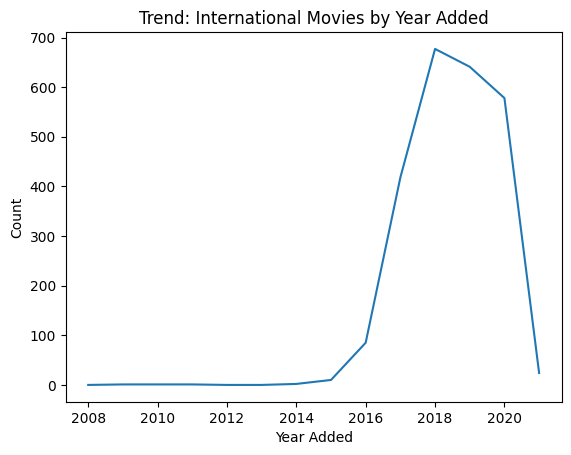

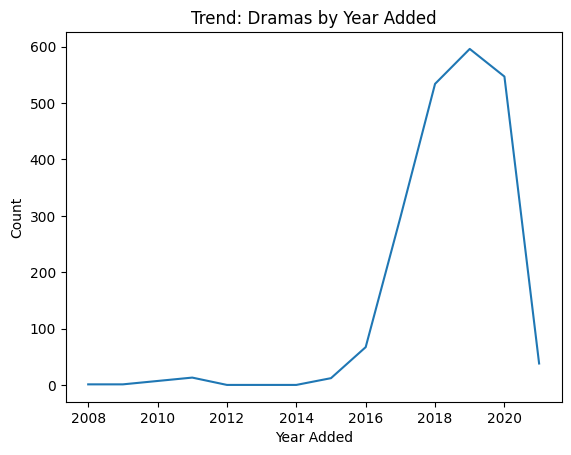

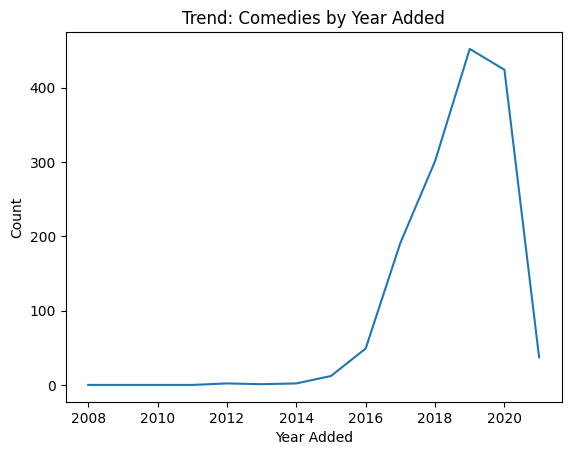

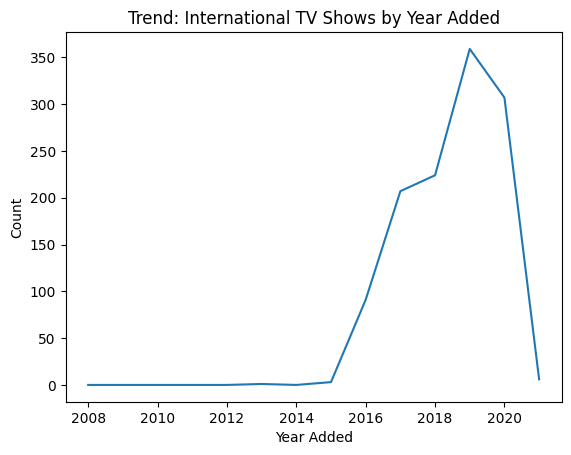

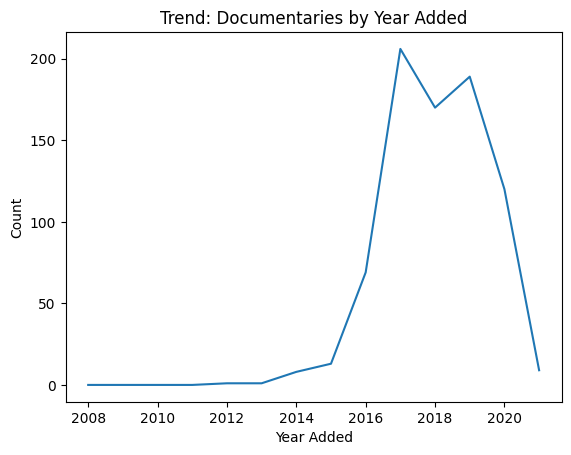

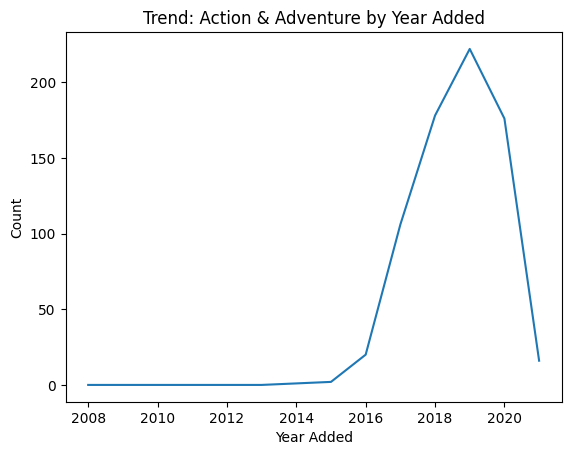

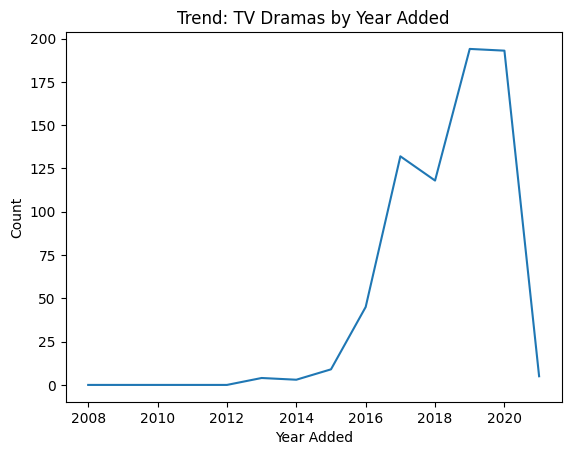

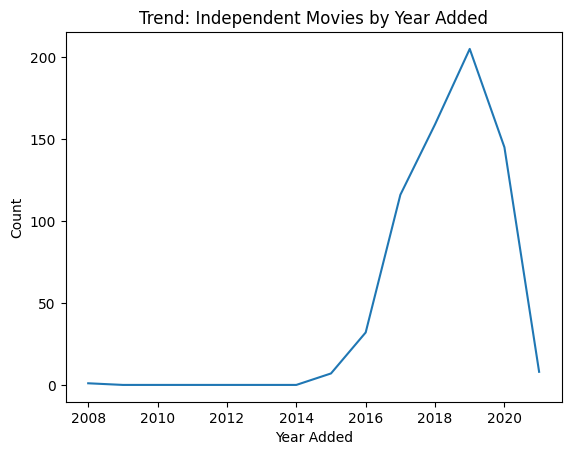

In [ ]:

# Genre trends by year_added for top genres
TOP_N = 8
if set(['Type','year_added']).issubset(df_clean.columns):
    exploded = df_clean.dropna(subset=['year_added']).copy()
    exploded['genre'] = exploded['Type'].str.split(',')
    exploded = exploded.explode('genre')
    exploded['genre'] = exploded['genre'].str.strip()
    exploded = exploded[exploded['genre']!='']
    top_genres = exploded['genre'].value_counts().head(TOP_N).index.tolist()
    subset = exploded[exploded['genre'].isin(top_genres)]
    genre_year = subset.groupby(['year_added','genre']).size().unstack(fill_value=0).sort_index()
    display(genre_year.tail(10))
    for g in top_genres:
        genre_year[g].plot(kind='line', title=f"Trend: {g} by Year Added")
        plt.xlabel('Year Added'); plt.ylabel('Count'); plt.show()
else:
    print("Columns missing for genre trend.")



## Country-wise Contributions (`Country`)


,count
Country,
United States,3297
India,990
United Kingdom,723
Unknown,507
Canada,412
France,349
Japan,287
Spain,215
South Korea,212


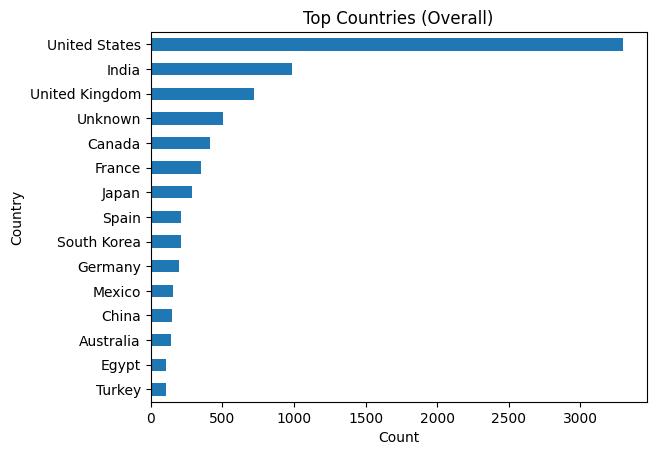

In [ ]:

if 'Country' in df_clean.columns:
    country_counts = split_explode_count(df_clean['Country'])
    display(country_counts.head(20))
    country_counts.head(15).sort_values(ascending=True).plot(kind='barh', title='Top Countries (Overall)')
    plt.xlabel('Count'); plt.ylabel('Country'); plt.show()
else:
    print("Column 'Country' not found.")


country_item,Canada,France,India,Japan,Spain,United Kingdom,United States,Unknown
year_added,,,,,,,,
2012.0,0,0,0,0,0,0,3,0
2013.0,1,0,0,0,0,1,10,0
2014.0,4,0,0,0,0,3,23,0
2015.0,8,9,0,1,0,8,60,5
2016.0,31,29,14,31,17,54,204,19
2017.0,71,54,163,45,43,134,471,66
2018.0,84,66,356,47,44,148,616,122
2019.0,90,84,241,78,59,199,926,160
2020.0,115,99,203,83,48,167,888,119


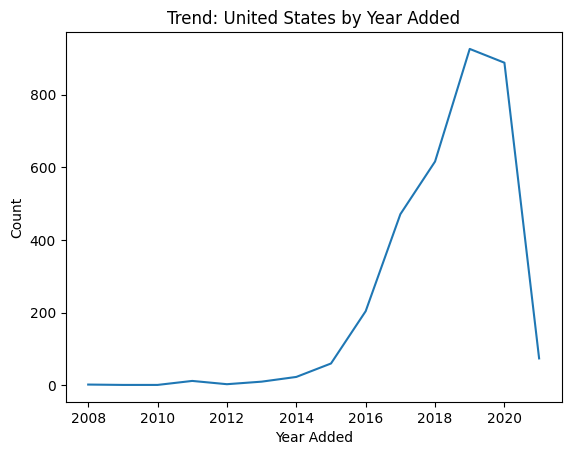

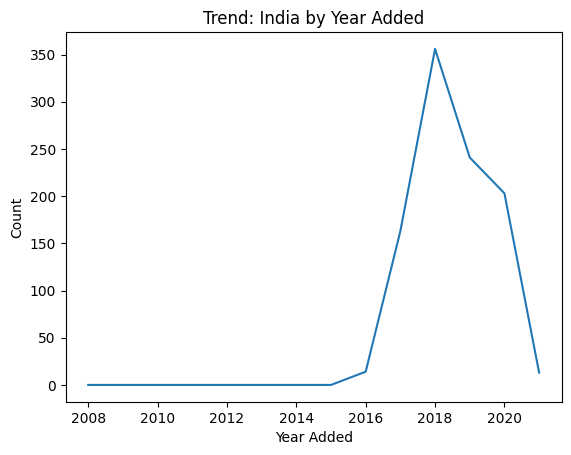

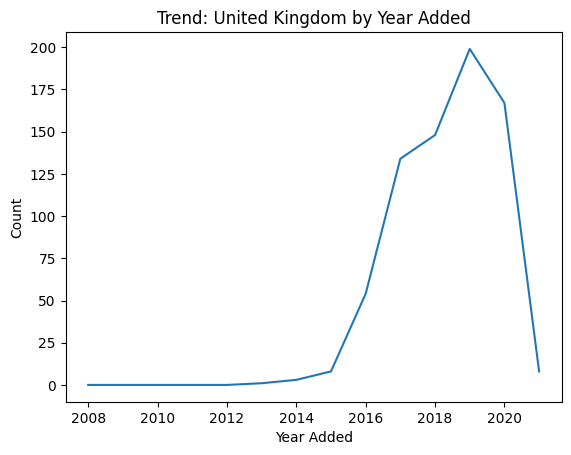

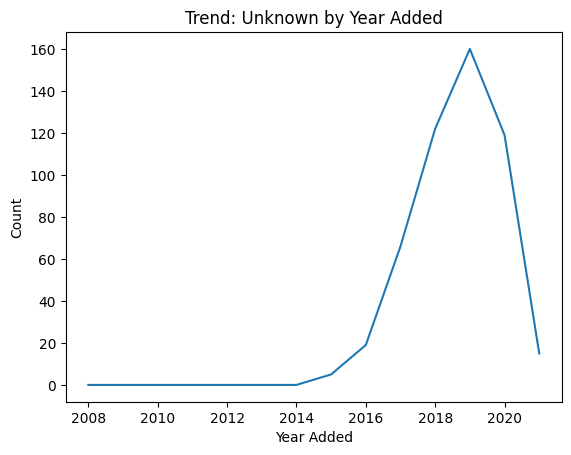

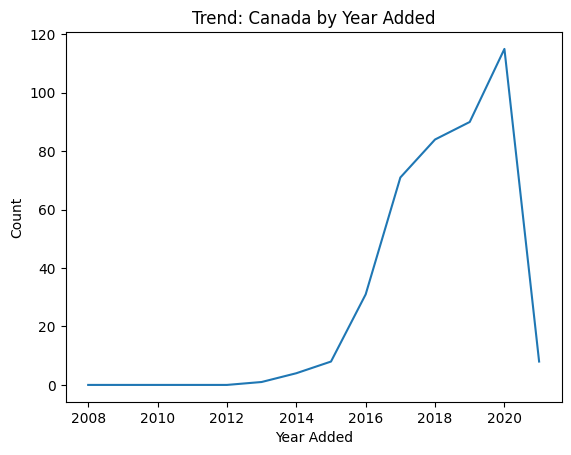

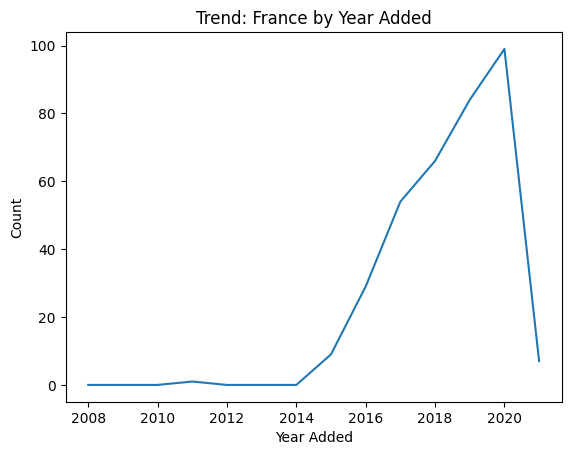

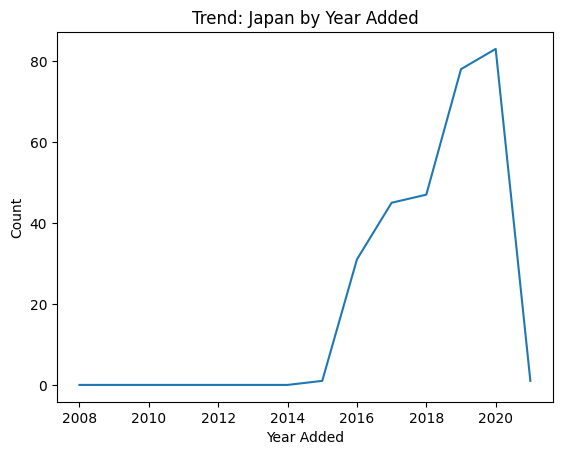

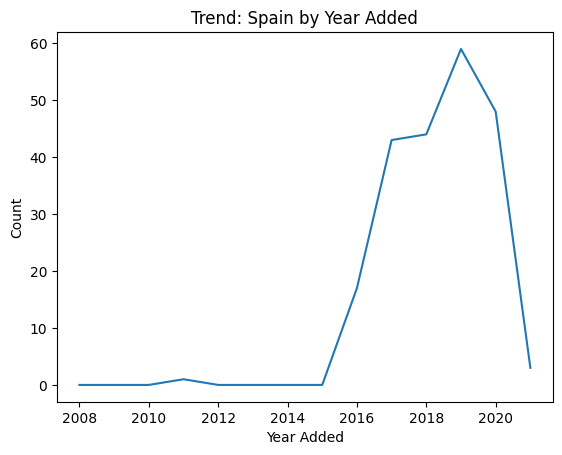

In [ ]:

# Country trends by year_added
TOP_N = 8
if set(['Country','year_added']).issubset(df_clean.columns):
    exploded = df_clean.dropna(subset=['year_added']).copy()
    exploded['country_item'] = exploded['Country'].str.split(',')
    exploded = exploded.explode('country_item')
    exploded['country_item'] = exploded['country_item'].str.strip()
    exploded = exploded[exploded['country_item']!='']
    top_countries = exploded['country_item'].value_counts().head(TOP_N).index.tolist()
    subset = exploded[exploded['country_item'].isin(top_countries)]
    country_year = subset.groupby(['year_added','country_item']).size().unstack(fill_value=0).sort_index()
    display(country_year.tail(10))
    for c in top_countries:
        country_year[c].plot(kind='line', title=f"Trend: {c} by Year Added")
        plt.xlabel('Year Added'); plt.ylabel('Count'); plt.show()
else:
    print("Columns missing for country trends.")



## Ratings & Duration
- **Rating** distribution
- **Duration** parsing (minutes vs seasons)


,count
Rating,
TV-MA,2863
TV-14,1931
TV-PG,806
R,665
PG-13,386
TV-Y,280
TV-Y7,271
PG,247
TV-G,194


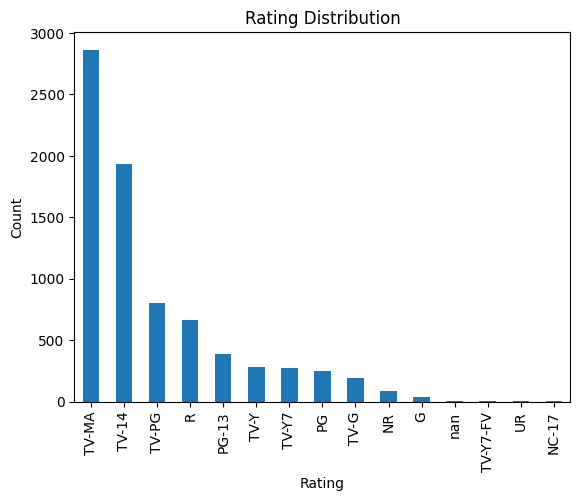

In [ ]:

# Rating distribution
if 'Rating' in df_clean.columns:
    rc = df_clean['Rating'].value_counts(dropna=False)
    display(rc)
    rc.plot(kind='bar', title='Rating Distribution')
    plt.xlabel('Rating'); plt.ylabel('Count'); plt.show()
else:
    print("Column 'Rating' not found.")


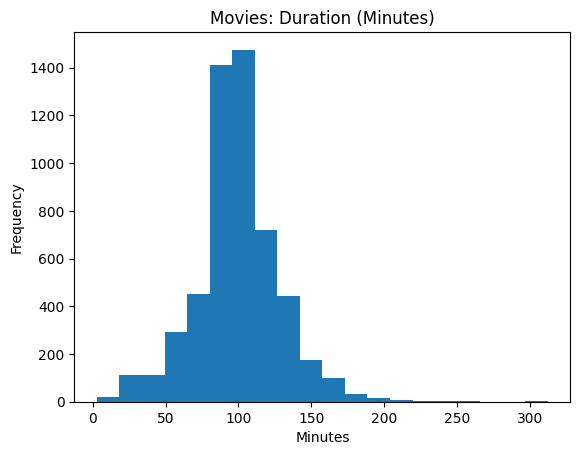

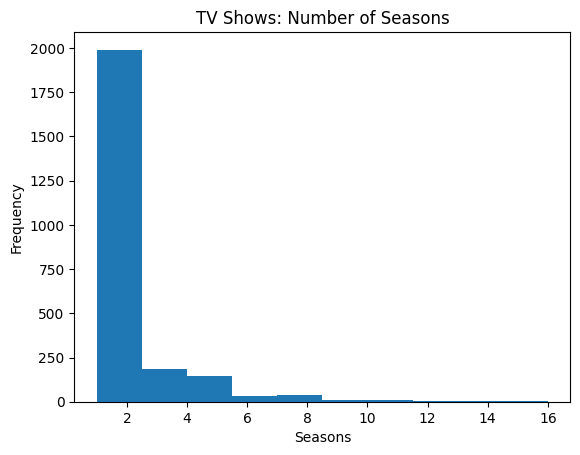

In [ ]:

# Duration parsing
if 'Duration' in df_clean.columns and 'Category' in df_clean.columns:
    durations = df_clean['Duration'].astype(str).str.extract(r'(?P<num>\d+)\s*(?P<unit>\w+)', expand=True)
    durations['num'] = pd.to_numeric(durations['num'], errors='coerce')
    df_clean['duration_num'] = durations['num']
    df_clean['duration_unit'] = durations['unit']

    movies = df_clean[(df_clean['Category']=='Movie') & (df_clean['duration_unit'].str.lower().str.startswith('min'))]
    if not movies.empty:
        movies['duration_num'].plot(kind='hist', bins=20, title='Movies: Duration (Minutes)')
        plt.xlabel('Minutes'); plt.ylabel('Frequency'); plt.show()

    shows = df_clean[(df_clean['Category']=='TV Show') & (df_clean['duration_unit'].str.lower().str.startswith('season'))]
    if not shows.empty:
        shows['duration_num'].plot(kind='hist', bins=10, title='TV Shows: Number of Seasons')
        plt.xlabel('Seasons'); plt.ylabel('Frequency'); plt.show()
else:
    print("Columns missing for duration analysis.")



## Key Findings (fill in after running)
- **Movies vs TV Shows:** …  
- **Top Genres:** …  
- **Top Countries:** …  
- **Ratings & Duration:** …  
